# Workgroup 4

- Janice Mamani

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#!pip install econml

import pandas as pd
import numpy as np
from scipy.stats import norm, ttest_ind, f_oneway

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from econml.grf import RegressionForest, CausalForest
from econml.dml import CausalForestDML
from econml.inference import BootstrapInference
from econml.sklearn_extensions.linear_model import WeightedLassoCV


# 1. Bootstraping


In [ ]:
## loading the data
Penn = pd.read_csv("/content/penn_jae.dat" , sep='\s', engine='python')
n = Penn.shape[0]
p_1 = Penn.shape[1]
Penn = Penn[ (Penn['tg'] == 4) | (Penn['tg'] == 0) ]
Penn.head()

,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep,q1,...,q5,q6,recall,agelt35,agegt54,durable,nondurable,lusd,husd,muld
0,10824,0,18,18,0,0,0,0,2,0,...,0,0,0,0,0,0,0,1,0,NaN
3,10824,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN
4,10747,0,27,27,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN
11,10607,4,9,9,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,NaN
12,10831,0,27,27,0,0,0,0,1,0,...,0,0,0,1,1,0,1,0,0,NaN


In [ ]:
# dependent variable
Penn['T4'] = (Penn[['tg']]==4).astype(int)

# Create category variable
Penn['dep'] = Penn['dep'].astype( 'category' )
Penn.head()

,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep,q1,...,q6,recall,agelt35,agegt54,durable,nondurable,lusd,husd,muld,T4
0,10824,0,18,18,0,0,0,0,2,0,...,0,0,0,0,0,0,1,0,NaN,0
3,10824,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,NaN,0
4,10747,0,27,27,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,NaN,0
11,10607,4,9,9,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,NaN,1
12,10831,0,27,27,0,0,0,0,1,0,...,0,0,1,1,0,1,0,0,NaN,0


In [ ]:
Penn["log(inuidur1)"] = np.log( Penn["inuidur1"] )

In [ ]:
Penn1 = pd.get_dummies(Penn["dep"], prefix='dep', dtype=int)
Penn1 = pd.DataFrame(Penn1)
Penn = pd.concat([Penn, Penn1], axis=1)
Penn


,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep,q1,...,durable,nondurable,lusd,husd,muld,T4,log(inuidur1),dep_0,dep_1,dep_2
0,10824,0,18,18,0,0,0,0,2,0,...,0,0,1,0,NaN,0,2.890372,0,0,1
3,10824,0,1,1,0,0,0,0,0,0,...,0,1,0,0,NaN,0,0.000000,1,0,0
4,10747,0,27,27,0,0,0,0,0,0,...,0,1,0,0,NaN,0,3.295837,1,0,0
11,10607,4,9,9,0,0,0,0,0,0,...,0,0,0,1,NaN,1,2.197225,1,0,0
12,10831,0,27,27,0,0,0,0,1,0,...,0,1,0,0,NaN,0,3.295837,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13904,10628,4,10,10,0,0,1,0,0,0,...,0,0,0,1,NaN,1,2.302585,1,0,0
13905,10523,4,4,4,0,0,1,0,2,0,...,0,0,0,1,NaN,1,1.386294,0,0,1
13906,10558,0,9,9,0,0,0,0,2,0,...,0,1,0,0,NaN,0,2.197225,0,0,1
13910,10817,4,4,4,0,0,0,0,0,0,...,0,0,0,0,NaN,1,1.386294,1,0,0


In [ ]:
#Reset the index
Penn=Penn.reset_index()
Penn.index

RangeIndex(start=0, stop=5099, step=1)

In [ ]:
def get_indices(data,num_samples):
    return  np.random.choice(data.index, num_samples, replace=True)

In [ ]:
#similar to boot.fn in R
def get_estimates(data,index):
    X = data[['T4','female','black','othrace','dep_1','dep_2','q2','q3','q4','q5','q6','agelt35','agegt54','durable','lusd','husd']].loc[index]
    y = data['log(inuidur1)'].loc[index]

    lr = LinearRegression()
    lr.fit(X,y)
    intercept = lr.intercept_
    coef = lr.coef_
    return [intercept,coef]


In [ ]:
get_estimates(Penn,np.arange(0,5099))

[1.7723227707334424,
 array([-0.07620609,  0.13812843, -0.30790531, -0.43972813,  0.05291891,
         0.12322238,  0.14990241,  0.05948183,  0.04518311,  0.13335249,
         0.36856411,  0.32957817,  0.1229282 , -0.20836448,  0.05875018,
         0.2070354 ])]

In [ ]:
def boot(data,func,R):
    coeff_1 = []
    coeff_2 = []
    coeff_3 = []

    for i in range(R):
        coeff_1.append(func(data,get_indices(data,n))[1][0])
        coeff_2.append(func(data,get_indices(data,n))[1][1])
        coeff_3.append(func(data,get_indices(data,n))[1][2])
    coeff_1_estimated_value = np.mean(coeff_1)
    coeff_2_estimated_value = np.mean(coeff_2)
    coeff_3_estimated_value = np.mean(coeff_3)
    coeff_1_std = np.std(coeff_1)
    coeff_2_std = np.std(coeff_2)
    coeff_3_std = np.std(coeff_3)
    return [coeff_1_estimated_value, coeff_1_std], [coeff_2_estimated_value, coeff_2_std],[coeff_3_estimated_value, coeff_3_std]


In [ ]:
results = boot(Penn,get_estimates,1000)


In [ ]:
results[0]

[-0.07623964744557658, 0.021205556077486247]

In [ ]:
results[1]

[0.13874000300671246, 0.021307646727919564]

In [ ]:
results[2]

[-0.30538453876897936, 0.03537288519743918]

# What if we run the regression once with the complete sample?

In [ ]:
X = Penn[['T4','female','black','othrace','dep_1','dep_2','q2','q3','q4','q5','q6','agelt35','agegt54','durable','lusd','husd']]
y = Penn['log(inuidur1)']
X = sm.add_constant(X)
ols = sm.OLS(y,X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          log(inuidur1)   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     12.51
Date:                Tue, 04 Jun 2024   Prob (F-statistic):           3.92e-33
Time:                        15:05:21   Log-Likelihood:                -8128.2
No. Observations:                5099   AIC:                         1.629e+04
Df Residuals:                    5082   BIC:                         1.640e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7723      0.049     36.011      0.0

## Histograms of the interest coefficients

<ipython-input-28-360d5712e9dd>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(results[1], bins=20)


Text(0.5, 1.0, "Histogram - T4's coefficient (Density)")

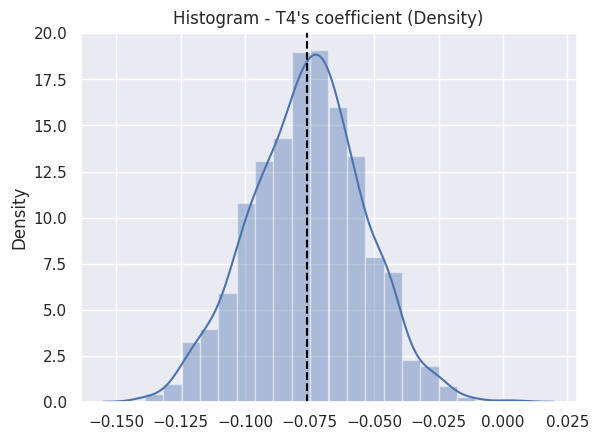

In [ ]:
sns.set_theme()
ax = sns.distplot(results[1], bins=20)

plt.axvline(x= -0.0762  , color='black', ls='--')
plt.title("Histogram - T4's coefficient (Density)")

<ipython-input-14-f44eb267e9bd>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(results[2], bins=20)


Text(0.5, 1.0, "Histogram - female's coefficient (Density)")

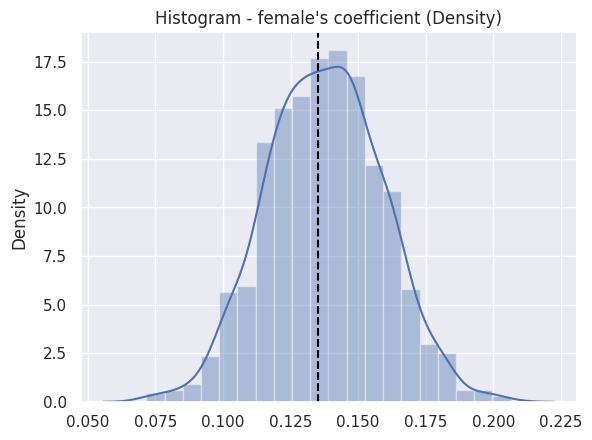

In [ ]:
sns.set_theme()
ax = sns.distplot(results[2], bins=20)

plt.axvline(x=  0.135  , color='black', ls='--')
plt.title("Histogram - female's coefficient (Density)")

<ipython-input-30-24f8ba7a8e7b>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(results[3], bins=20)


Text(0.5, 1.0, "Histogram - black's coefficient (Density)")

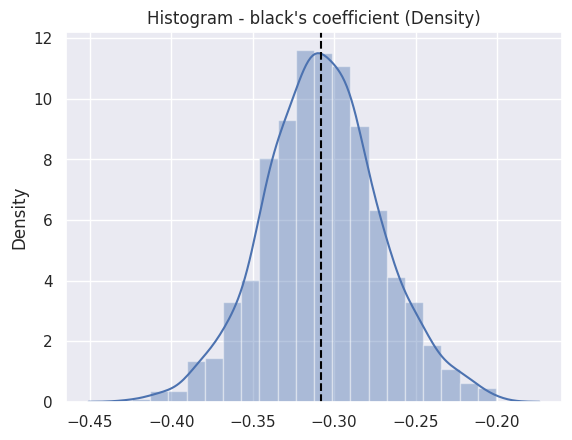

In [ ]:
sns.set_theme()
ax = sns.distplot(results[3], bins=20)

plt.axvline(x= -0.3079   , color='black', ls='--')
plt.title("Histogram - black's coefficient (Density)")

## Results

In [ ]:
coeff=(ols.params[1],ols.params[2], ols.params[3])
coeff
print(coeff[0],coeff[1],coeff[2])

-0.07620608596005415 0.13812843416296364 -0.3079053087767059


In [ ]:
table_1 = np.zeros( (3, 4) )

table_1[0,0] = ols.summary2().tables[1]['Coef.']['T4']
table_1[0,1] = results[0][0]
table_1[0,2] = ols.summary2().tables[1]['Std.Err.']['T4']
table_1[0,3] = results[0][1]

table_1[1,0] = ols.summary2().tables[1]['Coef.']['female']
table_1[1,1] = results[1][0]
table_1[1,2] = ols.summary2().tables[1]['Std.Err.']['female']
table_1[1,3] = results[1][1]

table_1[2,0] = ols.summary2().tables[1]['Coef.']['black']
table_1[2,1] = results[2][0]
table_1[2,2] = ols.summary2().tables[1]['Std.Err.']['black']
table_1[2,3] = results[2][1]

table1 = pd.DataFrame(table_1, columns = ["coef", "coef boot", "std err", "std err boot"], \
                      index = ["T4","female","black"])

table1

,coef,coef boot,std err,std err boot
T4,-0.076206,-0.076240,0.035288,0.021206
female,0.138128,0.138740,0.034614,0.021308
black,-0.307905,-0.305385,0.053482,0.035373


# Causal Forest

The paper "Estimating Treatment Effects with Causal Forests: An Application" by Susan Athey and Stefan Wager explores how causal forests, a machine learning technique, can estimate the impact of interventions. Using data from the National Study of Learning Mindsets, they analyze how a program aimed at promoting a growth mindset affects students' academic performance. The authors address challenges like confounding variables and clustered data to ensure accurate results. They highlight the practical benefits of using causal forests in educational research, showing how these methods can reveal the true effects of interventions and the role of different factors.

In [ ]:
# Load the data from the CSV file
data = pd.read_csv('/synthetic_data.csv')

# Display the first few rows of the DataFrame to verify
print(data.head())

   schoolid  Z         Y  S3  C1  C2  C3  XC        X1        X2        X3  \
0        76  1  0.081602   6   4   2   1   4  0.334544  0.648586 -1.310927   
1        76  1 -0.385869   4  12   2   1   4  0.334544  0.648586 -1.310927   
2        76  1  0.398184   6   4   2   0   4  0.334544  0.648586 -1.310927   
3        76  1 -0.175037   6   4   2   0   4  0.334544  0.648586 -1.310927   
4        76  1  0.884583   6   4   1   0   4  0.334544  0.648586 -1.310927   

         X4        X5  
0  0.224077 -0.426757  
1  0.224077 -0.426757  
2  0.224077 -0.426757  
3  0.224077 -0.426757  
4  0.224077 -0.426757  


In [ ]:
# Convert schoolid to a categorical variable
data['schoolid'] = data['schoolid'].astype('category')

DF = data.drop(columns=['schoolid'])

school_id = data['schoolid'].cat.codes.values

school_mat = pd.get_dummies(data['schoolid'], drop_first=False)
school_size = school_mat.sum().values

In [ ]:
# Prepare data for logistic regression
X = DF.drop(columns=['Z', 'Y'])
X = sm.add_constant(X)  # Add constant term for intercept
y = DF['Z']

# Fit logistic regression model
w_lm = sm.Logit(y, X).fit()

# Print summary of the logistic regression
print(w_lm.summary())

Optimization terminated successfully.
         Current function value: 0.627430
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      Z   No. Observations:                10391
Model:                          Logit   Df Residuals:                    10380
Method:                           MLE   Df Model:                           10
Date:                Fri, 07 Jun 2024   Pseudo R-squ.:                0.005764
Time:                        02:37:53   Log-Likelihood:                -6519.6
converged:                       True   LL-Null:                       -6557.4
Covariance Type:            nonrobust   LLR p-value:                 3.641e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0949      0.143     -7.678      0.000      -1.374      -0.815
S3             0.1022      0.

In [ ]:
# Extract W and Y from DF
W = DF['Z']
Y = DF['Y']

# Create X.raw by excluding the first two columns
X_raw = DF.iloc[:, 2:]

# Create dummy variables for categorical variables C1 and XC
C1_exp = pd.get_dummies(X_raw['C1'], prefix='C1', drop_first=False)
XC_exp = pd.get_dummies(X_raw['XC'], prefix='XC', drop_first=False)

# Combine the transformed X.raw
X = pd.concat([X_raw.drop(columns=['C1', 'XC']), C1_exp, XC_exp], axis=1)

# Add constant term for intercept
X = sm.add_constant(X)

In [ ]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute sample weights for school clusters
unique_schools, school_counts = np.unique(school_id, return_counts=True)
school_weights = {school: 1.0/count for school, count in zip(unique_schools, school_counts)}
sample_weights = np.array([school_weights[school] for school in school_id])

# Fit the regression forest for Y with sample weights
Y_forest = RegressionForest(n_estimators=500, min_samples_leaf=5)
Y_forest.fit(X_scaled, Y, sample_weight=sample_weights)
Y_hat = Y_forest.predict(X_scaled)

# Fit the regression forest for W with sample weights
W_forest = RegressionForest(n_estimators=500, min_samples_leaf=5)
W_forest.fit(X_scaled, W, sample_weight=sample_weights)
W_hat = W_forest.predict(X_scaled)

# Fit the causal forest without passing Y_hat and W_hat directly
cf_raw = CausalForest(n_estimators=500, min_samples_leaf=5, max_depth=None, min_samples_split=10,
                      min_impurity_decrease=1e-3, random_state=123)

cf_raw.fit(X_scaled, T=W, y=Y, sample_weight=sample_weights)

# Compute variable importance
varimp = cf_raw.feature_importances_

# Select variables with importance greater than the mean
selected_idx = np.where(varimp > np.mean(varimp))[0]

# Fit the causal forest using selected variables with sample weights
cf = CausalForest(n_estimators=500, min_samples_leaf=5, max_depth=None, min_samples_split=10,
                  min_impurity_decrease=1e-3, random_state=123)

X_selected = X_scaled[:, selected_idx]
cf.fit(X_selected, T=W, y=Y, sample_weight=sample_weights)

# Predict treatment effects
tau_hat = cf.predict(X_selected)

### 1. How the tree was built?
The tree is built using regression and causal forests. Initially, data is prepared and a logistic regression model is used to estimate the propensity score for treatment assignment. Then, two regression forests are grown to predict the outcome and the treatment assignment, respectively. These predictions are used to build a causal forest, which estimates the treatment effect while accounting for the clustering by school. This approach ensures that the analysis considers school-level differences and fairly estimates the treatment effect across all individuals.

## 2. Estimate ATE

In [ ]:
# Average Treatment Effect (ATE)
ATE = np.mean(tau_hat)

# Confidence Interval for ATE
ci_low = np.quantile(tau_hat, q=0.025)
ci_high = np.quantile(tau_hat, q=0.975)
ci = [ci_low, ci_high]

ATE_result = [ATE, ci]
print("The estimated ATE and it's confidence interval are:",ATE_result)

The estimated ATE and it's confidence interval are: [0.2598127061029671, [0.13362204509050646, 0.37757847899826735]]


The ATE measures the average impact of mindset training on schooling scores across all students. It is computed by aggregating individual treatment effect estimates from the causal forest. This metric provides a summary of how much, on average, the mindset training changes the schooling scores, offering a high-level view of the overall effectiveness of the intervention.

In [ ]:
# Reshape tau_hat to a 1D array
tau_hat_reshaped = tau_hat.ravel()

# Initialize and fit the best linear predictor (e.g., weighted lasso)
linear_predictor = WeightedLassoCV(cv=3)
linear_predictor.fit(X_selected, tau_hat_reshaped, sample_weight=sample_weights)

WeightedLassoCV(cv=3)

A best linear predictor analysis was conducted to understand the relationship between estimated treatment effects and student covariates. By fitting a linear regression model with predicted treatment effects as the dependent variable and student characteristics as independent variables, this analysis identifies which student features are most strongly associated with the effectiveness of mindset training.

In [ ]:
# Compare regions with high and low estimated CATEs
high_effect = tau_hat > np.median(tau_hat)

# Calculate the ATE for regions with high and low estimated CATEs
ate_high = np.mean(tau_hat[high_effect])
ate_low = np.mean(tau_hat[~high_effect])

# Calculate 95% CI for difference in ATE
diff_ate = ate_high - ate_low
se_diff_ate = np.sqrt(np.var(tau_hat[high_effect]) / np.sum(high_effect) + np.var(tau_hat[~high_effect]) / np.sum(~high_effect))
z = 1.96  # Z-score for 95% confidence interval
ci_low = diff_ate - z * se_diff_ate
ci_high = diff_ate + z * se_diff_ate

# Print 95% CI for difference in ATE
print("95% CI for difference in ATE: {:.3f} +/- {:.3f}".format(diff_ate, se_diff_ate))

95% CI for difference in ATE: 0.083 +/- 0.001
